In [1]:
%matplotlib inline
from __future__ import division, print_function, absolute_import
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math
from ssvmimp.imp_scores_helper import ImportanceScoresHelper

In [2]:
points = np.load("Circle.Points.1000.npy")
labels = np.load("Circle.Labels.1000.npy")

In [3]:
#print(points)
#print(labels)
#print(points[:-100,:].shape)

# Number of support vectors:
| C        | Gamma    | Number of Support Vectors | Accuracy | Comments |
|----------|----------|---------------------------|----------|----------|
|1         | 0.01     | 172                       | 1.00     |          |
|100       | 0.01     | 105                       | 1.00     |          |
|1         | 0.001    | 113                       | 1.00     |          |
|100       | 0.001    | 15                        | 1.00     | BEST     |
|1         | 0.0001   | 310                       | 1.00     |          |
|100       | 0.0001   | 47                        | 1.00     |          |

In [4]:
gamma=0.001
clf = SVC(C=100, gamma=gamma)
print(clf)
clf.fit(points[:-100,:], labels[:-100])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [5]:
numcorrect = 0
for (point, label) in zip(points[-100:,:], labels[-100:]):
    prediction = clf.predict([point])
#    print("Point: " + str(point) + " Label: " + str(label) + " Prediction: " + str(prediction))
    if label == prediction:
        numcorrect += 1
    else:
        print("INACCURATE PREDICTION!!: Point: " + str(point) + " Label: " + str(label) + " Prediction: " + str(prediction))
print("Accuracy: " + str(float(numcorrect)/100.0))

Accuracy: 1.0


In [6]:
#print(clf.support_.shape)

In [7]:
print(str(clf.support_vectors_.shape))

(15, 2)


In [8]:
prediction_at_support = np.empty(clf.support_vectors_.shape[0])
i = 0
for (x, y) in clf.support_vectors_:
    prediction_at_support[i] = clf.predict([[x,y]])
    i += 1
print(prediction_at_support.shape)
#print(prediction_at_support)

(15,)


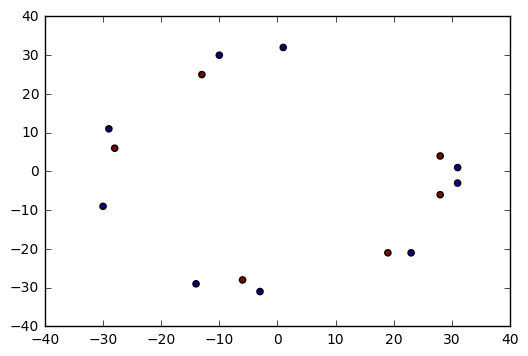

In [9]:
plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c=prediction_at_support[:] )
plt.show()

In [10]:
num_support_vectors = clf.dual_coef_.shape[1]
print(num_support_vectors)

15


In [11]:
clf.decision_function(clf.support_vectors_)

array([-1.00003716, -1.00001205, -1.00023587, -0.99996649, -1.00014605,
       -1.00027115, -0.99997738, -1.00002945, -0.99976867,  1.00023734,
        1.0001856 ,  0.99965716,  1.00040347,  0.86068772,  0.99996566])

In [12]:
ish = ImportanceScoresHelper(clf, points, labels)

In [13]:
testpoints = np.empty((0,2), dtype=float)
for x in range(-50,60,20):
    for y in range(-50,60,20):
        testpoints = np.append(testpoints, [[x,y]], axis=0)

In [14]:
raw_pred = clf.decision_function(testpoints)

In [15]:
ref_points = ish.get_reference_points_from_closest_opposite_points(testpoints)

In [16]:
avg_gradients = ish.get_average_gradient_between_points(ref_points, testpoints)

In [17]:
imp_scores = ish.get_feature_contribs_using_average_gradient_from_reference(testpoints)

In [18]:
testpoints.shape

(36, 2)

In [19]:
raw_pred.shape

(36,)

In [20]:
avg_gradients.shape

(36, 2)

In [21]:
ref_points.shape

(36, 2)

In [22]:
imp_scores.shape

(36, 2)

In [23]:
display_points = np.empty((0,9), dtype=float)
for i in range(testpoints.shape[0]):
    display_points = np.append(display_points, [[testpoints[i,0], testpoints[i,1], raw_pred[i],
                                                imp_scores[i,0], imp_scores[i,1], 
                                                avg_gradients[i,0], avg_gradients[i,1],
                                                ref_points[i,0], ref_points[i,1]]], axis=0)

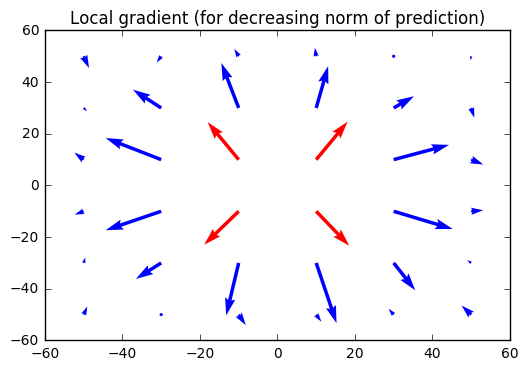

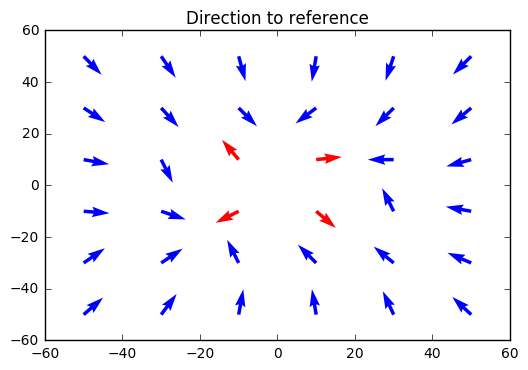

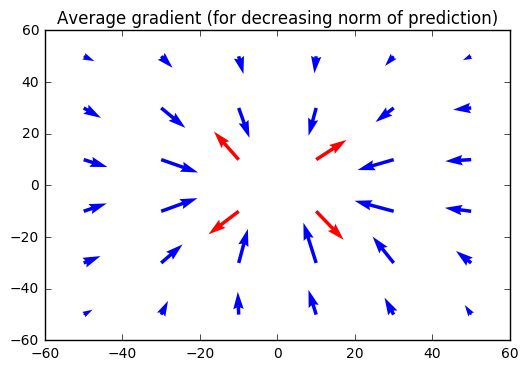

In [24]:
#gradient at each point
grad_per_point = np.array([ish.get_gradient(x) for x in testpoints])
plt.quiver(display_points[:,0], display_points[:,1],
           -grad_per_point[:,0], -grad_per_point[:,1],
           color=[(1,0,0) if x==1 else (0,0,1) for x in np.sign(display_points[:,2])])
plt.title("Local gradient (for decreasing norm of prediction)")
plt.show()

#unit norm direction to reference
dir_to_ref = display_points[:,7:9] - display_points[:,:2]
dir_to_ref = dir_to_ref/np.linalg.norm(dir_to_ref, axis=1)[:,None]
plt.quiver(display_points[:,0], display_points[:,1],
           dir_to_ref[:,0], dir_to_ref[:,1],
           color=[(1,0,0) if x==1 else (0,0,1) for x in np.sign(display_points[:,2])])
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.title("Direction to reference")
plt.show()

#avg grad
plt.quiver(display_points[:,0], display_points[:,1],
           -np.sign(display_points[:,2])*display_points[:,5],
           -np.sign(display_points[:,2])*display_points[:,6],
           color=[(1,0,0) if x==1 else (0,0,1) for x in np.sign(display_points[:,2])])
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.title("Average gradient (for decreasing norm of prediction)")
plt.show()

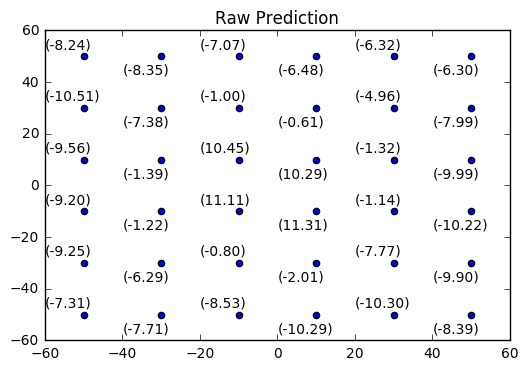

In [25]:
plt.scatter(display_points[:,0], display_points[:,1])
for i in range(display_points.shape[0]):
    x = display_points[i][0]
    y = display_points[i][1]
    raw_pred = display_points[i][2]
    if (x+10)/20 % 2 == 0:
        plt.annotate('(%5.2f)' %(raw_pred), xy=(x,y), xytext=(x-10,y+3))
    else:
        plt.annotate('(%5.2f)' %(raw_pred), xy=(x,y), xytext=(x-10,y-7))
plt.title('Raw Prediction')
plt.show()